In [53]:
# python3 -m venv env
# source env/bin/activate
# Install below packages in the virtual env created
# pip3 install langgraph-supervisor==0.0.4 
# pip3 install langchain-openai==0.3.6 
# pip3 install langgraph==0.2.74 
# pip3 install langgraph-sdk==0.1.51
# pip3 install langchain==0.3.19
# pip3 install langgraph-prebuilt==0.1.1
# pip3 install langgraph-checkpoint==2.0.16

SyntaxError: invalid syntax (1975131222.py, line 1)

In [ ]:
import os

# Set the environment variables with the Azure OpenAI deployment details
os.environ["AZURE_OPENAI_DEPLOYMENT"] = "gpt-4o"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-08-01-preview"
os.environ["AZURE_OPENAI_ENDPOINT"]= ""
os.environ["AZURE_OPENAI_API_KEY"] = ""

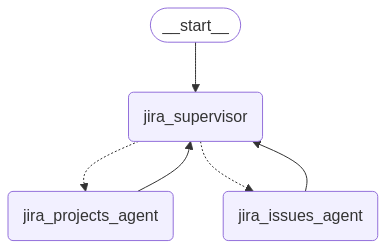


User prompt: create a project for my venture test-venture-1

create_jira_project - Received input: op_type='create_jira_project' name='test-venture-1'

Tool: create_jira_project, Content: response='Created Jira project: test-venture-1 with id: 1234'

 {"response":"Created Jira project: test-venture-1 with id: 1234"}

User prompt: 1. create a project for my venture test-venture-2 2. get the project details for it

create_jira_project - Received input: op_type='create_jira_project' name='test-venture-2'

get_jira_project - Received input: op_type='get_jira_project' name='test-venture-2'

Tool: create_jira_project, Content: response='Created Jira project: test-venture-2 with id: 1234'

Tool: get_jira_project, Content: response='Got Jira project: test-venture-2 with id: 1234 and owner: John Doe'

 {"response":"Created Jira project: test-venture-2 with id: 1234,Got Jira project: test-venture-2 with id: 1234 and owner: John Doe"}

User prompt: 1. create a project for my venture test-venture

In [82]:

import string
import json
import uuid
from typing import TypedDict, Annotated, List, Literal

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

from langchain_openai import AzureChatOpenAI

from pydantic import BaseModel

from IPython.display import Image, display

model = AzureChatOpenAI(
    azure_deployment="gpt-4o",  # Replace with your deployment name
    api_version="2024-08-01-preview",  # Use the correct API version
    temperature=0
)

# class State(TypedDict, total=False):
#     messages: Annotated[List[BaseMessage], add_messages]
# 
# state: State = State()
# 
# def get_state():
#     return state

# Final output to caller
class JiraOutput(BaseModel):
    """
    The output.
        Attributes:
        response (str): detail response.
    """
    response: str

def get_tool_output(result) -> JiraOutput:
    supported_tools = ["create_jira_project", 
                       "get_jira_project", 
                       "get_jira_issue_by_project_name"]
    try:
        # Check if 'messages' key exists in the result
        response_to_send_list: List[str] = []
        if 'messages' in result:
            for message in result['messages']:
                if hasattr(message, 'tool_call_id'):
                    # print("\n", message)
                    if message.name in supported_tools:
                        if hasattr(message, 'content'):
                            print(f"\nTool: {message.name}, Content: {message.content}")
                            # message.content is a string, ideally we would want the structured_json here
                            # parse the content to get the required output
                            output = message.content 
                            token = "="
                            output_after_token = output.partition(token)[2].strip('\'')
                            # append results for all tools
                            if output_after_token:
                                response_to_send_list.append(output_after_token)
                                #return JiraOutput(response=output_after_token)
                            #return JiraOutput(response="error performing the operation")
        else:
            print("Error: 'messages' not found in the result")
            return JiraOutput(response="error performing the operation")
        
        # cumulative response from all tools
        if len(response_to_send_list) > 1:
            response_to_send = ",".join(response_to_send_list)
        else:
            response_to_send = response_to_send_list[0]
            
        return JiraOutput(response=response_to_send)
    
    except Exception as e:
        print(f"Exception: {e}")
        return JiraOutput(response="error performing the operation")

# Create specialized agents

# this model should be generic for all responses to be sent from Jira issues agent
# for each tool handled by this agent
class JiraIssueOutput(BaseModel):
    """
    The output.
        Attributes:
        response (str): detail response from tool.
    """
    # status_code: int
    response: str

class GetJiraIssueByProjectNameInput(BaseModel):
    """
    The input for getting a Jira issue by project name.
        Attributes:
        op_type : Literal["get_jira_issue_by_project_name"]
        project_name (str): The name of the project.
    """
    op_type: Literal["get_jira_issue_by_project_name"]
    project_name: str

# Agent 1 (Jira Issues)
def get_jira_issue_by_project_name(input: GetJiraIssueByProjectNameInput) -> JiraIssueOutput:
    """get a jira issue and return the output.
         Args:
         input (GetJiraIssueByProjectNameInput):
             The user-provided input that guides the jira issue retrieval. 
             This request is serialized from a `GetJiraIssueByProjectNameInput` object,
             which must have a `model_dump()` method for JSON conversion.
         
     Returns:
         JiraIssueOutput:
             A JSON representation of the JiraIssueOutput.
             This response is serialized from a `JiraIssueOutput` object,
             which must have a `model_dump()` method for JSON conversion.
    """
    print("\nget_jira_issue_by_project_name - Received input:", input)
    if not input or input is None:
        return JiraIssueOutput(response="error performing the operation")
    
    response_str = f"Got Jira issue for project: {input.project_name} with id: 5678"
    return JiraIssueOutput(response=response_str)


jira_issues_agent = create_react_agent(
    model=model,
    tools=[get_jira_issue_by_project_name],
    name="jira_issues_agent",
    # prompt="You are a helpful agent. Only use the tools available. You must not validate the inputs or generate your own responses. Only use the tools Tool Message response as your final response.",
    prompt="You are a helpful agent. Only use the tools available."
)

# this model should be generic for all responses to be sent from Jira projects agent
# for each tool handled by this agent
class JiraProjectOutput(BaseModel):
    """
    The output.
        Attributes:
        response (str): detail response.
    """
    # status_code: int
    response: str

class CreateJiraProjectInput(BaseModel):
    """
    The input for creating a Jira project.
        Attributes:
        op_type : Literal["create_jira_project"]
        name (str): The name of the project.
    """
    op_type: Literal["create_jira_project"]
    name: str

# Agent 2 (Jira Projects)
def create_jira_project(input: CreateJiraProjectInput) -> JiraProjectOutput:
    """create a jira project and return the output.
         Args:
         input (CreateJiraProjectInput):
             The user-provided input that guides the jira project creation. 
             This request is serialized from a `CreateJiraProjectInput` object,
             which must have a `model_dump()` method for JSON conversion.
         
     Returns:
         JiraProjectOutput:
             A JSON representation of the JiraProjectOutput.
             This response is serialized from a `JiraProjectOutput` object,
             which must have a `model_dump()` method for JSON conversion.
    """
    print("\ncreate_jira_project - Received input:", input)
    if not input or input is None:
        return JiraProjectOutput(response="error performing the operation")
    
    response_str = f"Created Jira project: {input.name} with id: 1234"
    return JiraProjectOutput(response=response_str)

class GetJiraProjectInput(BaseModel):
    """
    The input for get on a Jira project.
        Attributes:
        op_type : Literal["get_jira_project"]
        name (str): The name of the project.
    """
    op_type: Literal["get_jira_project"]
    name: str

# Agent 2 (Jira Projects)
def get_jira_project(input: GetJiraProjectInput) -> JiraProjectOutput:
    """get a jira project and return the output.
         Args:
         input (GetJiraProjectInput):
             The user-provided input that guides the jira project retrieval. 
             This request is serialized from a `GetJiraProjectInput` object,
             which must have a `model_dump()` method for JSON conversion.
         
     Returns:
         JiraProjectOutput:
             A JSON representation of the JiraProjectOutput.
             This response is serialized from a `JiraProjectOutput` object,
             which must have a `model_dump()` method for JSON conversion.
    """
    print("\nget_jira_project - Received input:", input)
    if not input or input is None:
        return JiraProjectOutput(response="error performing the operation")
    
    response_str = f"Got Jira project: {input.name} with id: 1234 and owner: John Doe"
    return JiraProjectOutput(response=response_str)


jira_projects_agent = create_react_agent(
    model=model,
    tools=[create_jira_project, get_jira_project],
    name="jira_projects_agent",
    # prompt="You are a helpful agent. Only use the tools available. You must not validate the inputs or generate your own responses. Only use the tools Tool Message response as your final response.",
    prompt="You are a helpful agent. Only use the tools available.",
    response_format=JiraProjectOutput
)

# Create supervisor workflow
workflow = create_supervisor(
    supervisor_name="jira_supervisor",
    agents=[jira_projects_agent, jira_issues_agent],
    model=model,
    # prompt=(
    #     "You are a team supervisor managing a jira projects agent and a jira issues agent."
    #     "For any jira projects only use the jira_projects_agent."
    #     "For any jira issues only use the jira_issues_agent."
    #     "If an agent is not found, return error message to the caller."
    # ),
    prompt=(
        "You are a team supervisor managing the provided jira agents. "
        "Only use the agents provided"
        "If an agent is not found, return error message to the caller."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
)

checkpointer = InMemorySaver()

try:
    
    # Compile graph - can be done once and reused
    app = workflow.compile(checkpointer=checkpointer)

    # View Graph
    display(Image(app.get_graph().draw_mermaid_png()))

    # pass unique thread_id for each invoke
    # config = {"configurable": {"thread_id": uuid.uuid4()}}
    
    # SAMPLES USING user-input = prompt
    
    # single agent and tool
    user_prompt = "create a project for my venture test-venture-1"
    print(f"\nUser prompt: {user_prompt}")
    result = app.invoke({
        "messages": [
            {
                "role": "user",
                "content": user_prompt
            }
        ],
    }, {"configurable": {"thread_id": uuid.uuid4()}})
    print("\n", get_tool_output(result).model_dump_json())
    
    # across 2 tools under same agent
    user_prompt = "1. create a project for my venture test-venture-2 2. get the project details for it"
    print(f"\nUser prompt: {user_prompt}")
    result = app.invoke({
        "messages": [
            {
                "role": "user",
                "content": user_prompt
            }
        ],
    }, {"configurable": {"thread_id": uuid.uuid4()}})

    print("\n", get_tool_output(result).model_dump_json())

    # across tools in 2 agents 
    user_prompt = "1. create a project for my venture test-venture-1 2. get issues for project test-venture-1"
    print(f"\nUser prompt: {user_prompt}")
    result = app.invoke({
        "messages": [
            {
                "role": "user",
                "content": user_prompt
            }
        ],
    }, {"configurable": {"thread_id": uuid.uuid4()}})
    print("\n", get_tool_output(result).model_dump_json())
    
    # SAMPLES (non-NLP) USING predefined user-input req body
    
    # working input format: create project
    # jira_input = CreateJiraProjectInput(op_type="create_jira_project", 
    #                                         name="Project 1")
    # invalid input examples
    # jira_input = CreateJiraProjectInput(op_type="create_issue", 
    #                                     name="Project 1") # invalid op_type
    # jira_input = CreateJiraProjectInput(op_type=CREATE_JIRA_PROJECT_TYPE) #missing field name
    
    # result = app.invoke({
    #     "messages": [
    #         {
    #             "role": "user",
    #             "content": jira_input.model_dump_json()
    #         }
    #     ],
    # }, {"configurable": {"thread_id": uuid.uuid4()}})
    # print(f"Structured result:\n", result["structured_response"])
    
    # working input format: get project
    # jira_input = GetJiraProjectInput(op_type="get_jira_project", 
    #                                     name="Project 1")
    # invalid input examples
    # jira_input = GetJiraProjectInput(op_type="get_issue", 
    #                                     name="Project 1") # invalid op_type
    # jira_input = GetJiraProjectInput(op_type=GET_JIRA_PROJECT_TYPE) #missing field name
    
    # result = app.invoke({
    #     "messages": [
    #         {
    #             "role": "user",
    #             "content": jira_input.model_dump_json()
    #         }
    #     ],
    # }, {"configurable": {"thread_id": uuid.uuid4()}})
    # print(f"Structured result:\n", result["structured_response"])
    
    # for m in result["messages"]:
    #     m.pretty_print()
except Exception as e:
    print(f"Exception: {e}")
    # return appropriate response to caller
    

    
